device: cpu
test dataset: (65536, 2) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


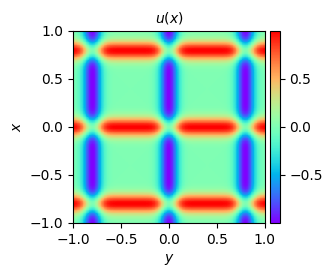

<AxesSubplot: title={'center': '$u(x)$'}, xlabel='$y$', ylabel='$x$'>

In [1]:
import numpy as np
import torch

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''
def poisson2d_gt(x,y):
    return np.exp(-np.square(10*x-8)) - np.exp(-np.square(10*y-8)) +\
        np.exp(-np.square(10*x+8)) - np.exp(-np.square(10*y+8)) +\
        np.exp(-np.square(10*x)) - np.exp(-np.square(10*y))

x = np.linspace(-1, 1, 256)
y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(x,y)
U_gt = poisson2d_gt(X, Y)

x_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_test = U_gt.flatten()[:,None]
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
print(PINN)
plot_u(U_gt, x, y, title="$u(x)$")

(x, t): (256, 256)


<AxesSubplot: title={'center': '$u(x,y)$'}, xlabel='$y$', ylabel='$x$'>

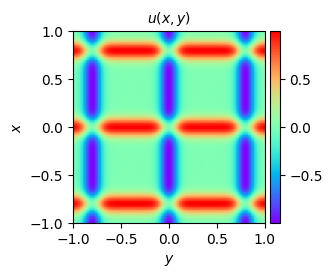

In [2]:
def poisson2d_gt(x,y):
    return np.exp(-np.square(10*x-8)) - np.exp(-np.square(10*y-8)) +\
        np.exp(-np.square(10*x+8)) - np.exp(-np.square(10*y+8)) +\
        np.exp(-np.square(10*x)) - np.exp(-np.square(10*y))
    
x = np.linspace(-1, 1, 256)
y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(x,y)
U_gt = poisson2d_gt(X, Y)

# test dataset
x_y_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_test = U_gt.flatten()[:,None]
# training dataset

x_y_train, x_y_boundary, u_boundary = training_data_latin_hypercube(X, Y, U_gt, N_inner=n_inner)

print("(x, t):", U_gt.shape)
plot_u(U_gt, x, y)

In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=1000, \
    lb=[-1,-1], ub=[1,1], steps=20, eps=1e-1, eta=2e-2, m=1):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, optimizer, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5):
    
    f_test_pred = np.abs(PINN.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(f_test_pred.reshape(X.shape).T, x, t, log=True, title="test $r(x;theta)$")

    model.iter = 0
    model.train_model_adam(optimizer, x_boundary, u_boundary, np.vstack([x_train, x_adv]), epoch)
                           
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
                           
    plot_u_x(u_pred.reshape(X.shape).T, U_gt, x, t)
    plot_u(np.abs(u_pred.reshape(X.shape).T-U_gt), x, t, log=True, title="$|u(x;theta)-u(x)|$")

In [ ]:
''' k=0 '''
N0 = 500
x_train, x_boundary, u_boundary = training_data_latin_hypercube(X, T, U_gt, N_inner=N0)
retrain(PINN, optimizer, x_train, np.array([]).reshape((0,2)), \
    x_boundary, u_boundary, x_test, u_test, U_gt)

In [ ]:
''' k=1 '''
x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=500)
retrain(PINN, optimizer, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=2e5)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)
Test Error: 4.27067


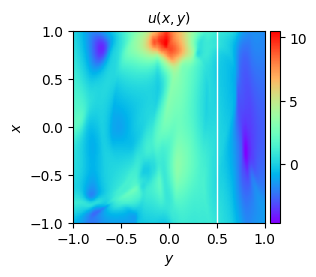

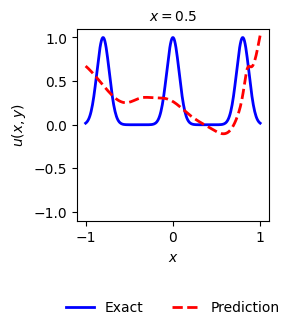

In [3]:
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, device)
       
PINN.to(device)
print(PINN)

'''
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
PINN.train_model_adam(optimizer, x_y_boundary, u_boundary, x_y_train, 200000)


with open("model.pickle", "wb") as fp:
    pickle.dump(PINN.state_dict(), fp)
    
with open("points.pickle", "wb") as fp:
    pickle.dump({"x_y_train":x_y_train, "x_y_boundary":x_y_boundary, "u_boundary":u_boundary}, fp)
'''

# Load Model
with open("model.pickle", "rb") as fp:
    PINN.load_state_dict(pickle.load(fp))
    
with open("points.pickle", "rb") as fp:
    points = pickle.load(fp)
    x_y_train = points["x_y_train"]
    x_y_boundary = points["x_y_boundary"]
    u_boundary = points["u_boundary"]


error_vec, u_pred = PINN.test(x_y_test, u_test)
print('Test Error: %.5f'  % (error_vec))
plot_u_x(u_pred, U_gt, x, y)




<AxesSubplot: title={'center': '$u(x,y)$'}, xlabel='$y$', ylabel='$x$'>

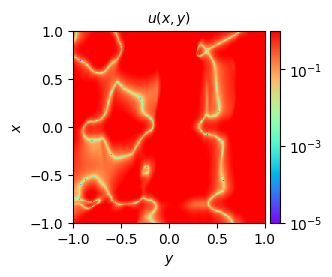

In [4]:
plot_u(np.abs(u_pred-U_gt), x, y, log=True)

In [5]:
from used_attacks import MIFGSM,PGD
import matplotlib.pyplot as plt
import matplotlib.colors as cls


def generate_attack_samples(model, device, x_y_train, n_samples=1000, steps=20, eps=1e-1, alpha=2e-2):
    f_pred = PINN.function(torch.from_numpy(x_y_train).float().to(device)).squeeze().cpu().detach().numpy()
    
    attack = PGD(PINN, device, steps=steps, loss= nn.L1Loss(), eps=eps, alpha=alpha)
    x_y_adv = attack(torch.from_numpy(x_y_train).float()).cpu().detach().numpy()
    if n_inner + 2*n_samples < x_y_adv.shape[0]:
        x_y_adv = np.vstack([x_y_adv[:n_inner,:] ,x_y_adv[-2*n_samples:,:]])

    f_adv_pred = PINN.function(torch.from_numpy(x_y_adv).float().to(device))
    index = np.argsort(np.abs(f_adv_pred.squeeze().cpu().detach().numpy()))[::-1][:n_samples]

    x_y_adv = x_y_adv[index,:]
    f_adv_pred = f_adv_pred.squeeze().cpu().detach().numpy()[index]

    err_random = np.mean(np.square(f_adv_pred))
    print("Adversarial sample error:   ", err_random)


    plt.figure(figsize=(3,3))
    plt.scatter(x_y_adv[:,1],x_y_adv[:,0], c=np.abs(f_adv_pred), \
        cmap="rainbow", s=5)


    plt.scatter(x_y_train[:,1],x_y_train[:,0], c=np.abs(f_pred), \
        cmap="binary", s=5)

    plt.xlabel('adversarial samples, %.5f' % err_random)

    plt.axis('square')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.colorbar()
    
    plt.figure(figsize=(3,3))
    plt.scatter(x_y_adv[:,1],x_y_adv[:,0], c=np.abs(f_adv_pred), \
        cmap="rainbow", s=5)

    plt.xlabel('adversarial samples, %.5f' % err_random)

    plt.axis('square')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.colorbar()
    
    f_test_pred = PINN.function(torch.from_numpy(x_y_test).float().to(device)).squeeze().cpu().detach().numpy().reshape(256,256)
    plot_u(np.abs(f_test_pred), x, y)
    return x_y_adv


def retrain(model, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt, epoch=5e4):

    x_y_train_temp = np.vstack([x_y_train, x_y_adv])
    PINN.iter = 0
    optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
    PINN.train_model_adam(optimizer, x_y_boundary, u_boundary, x_y_train_temp, epoch)
    error_vec, u_pred = PINN.test(x_y_test, u_test)
    print('Test Error: %.5f'  % (error_vec))
    plot_u_x(u_pred, U_gt, x, y)
    plot_u(np.abs(u_pred-U_gt), x, y, log=True)

Adversarial sample error:    449016.94


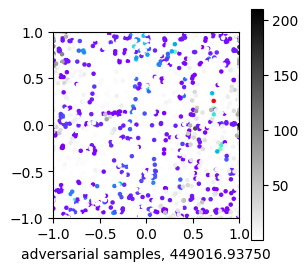

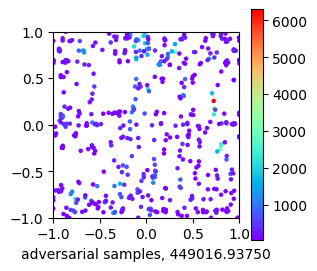

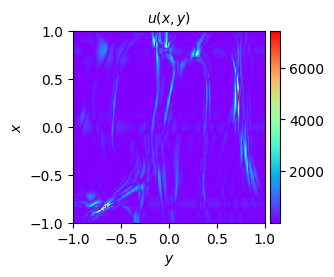

In [6]:
x_y_adv = generate_attack_samples(PINN, device, x_y_train, n_samples=500)

100 tensor(57802., device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(39498.6250, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(30593.2891, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(25221.9785, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(21543.5176, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(18803.4102, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(16598.1992, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(14622.9688, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(13238.9766, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(12207.4512, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(11366.0791, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(10667.4014, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(10074.2285, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(9558.3633, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(9100.2754, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(8687.3232, device='cuda:0', 

12900 tensor(2641.7817, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2691.5559, device='cuda:0', grad_fn=<AddBackward0>)
13100 tensor(2622.4871, device='cuda:0', grad_fn=<AddBackward0>)
13200 tensor(2613.0713, device='cuda:0', grad_fn=<AddBackward0>)
13300 tensor(2604.3462, device='cuda:0', grad_fn=<AddBackward0>)
13400 tensor(2594.5769, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(2584.7832, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(2575.4941, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(2566.2036, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(2557.1597, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(2547.6951, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2539.6255, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(2530.8384, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(2520.1194, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(2513.5430, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(2508.0625, d

25600 tensor(1816.9159, device='cuda:0', grad_fn=<AddBackward0>)
25700 tensor(1813.5717, device='cuda:0', grad_fn=<AddBackward0>)
25800 tensor(1811.6233, device='cuda:0', grad_fn=<AddBackward0>)
25900 tensor(1809.5035, device='cuda:0', grad_fn=<AddBackward0>)
26000 tensor(1802.8455, device='cuda:0', grad_fn=<AddBackward0>)
26100 tensor(1799.3656, device='cuda:0', grad_fn=<AddBackward0>)
26200 tensor(1795.8971, device='cuda:0', grad_fn=<AddBackward0>)
26300 tensor(1798.9727, device='cuda:0', grad_fn=<AddBackward0>)
26400 tensor(1789.6116, device='cuda:0', grad_fn=<AddBackward0>)
26500 tensor(1785.3467, device='cuda:0', grad_fn=<AddBackward0>)
26600 tensor(1783.2640, device='cuda:0', grad_fn=<AddBackward0>)
26700 tensor(1779.1924, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(1784.7985, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1771.3380, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1767.8446, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1767.0411, d

38300 tensor(1612.6427, device='cuda:0', grad_fn=<AddBackward0>)
38400 tensor(1610.9557, device='cuda:0', grad_fn=<AddBackward0>)
38500 tensor(1605.6838, device='cuda:0', grad_fn=<AddBackward0>)
38600 tensor(1611.3016, device='cuda:0', grad_fn=<AddBackward0>)
38700 tensor(1597.8516, device='cuda:0', grad_fn=<AddBackward0>)
38800 tensor(1597.5872, device='cuda:0', grad_fn=<AddBackward0>)
38900 tensor(1590.8518, device='cuda:0', grad_fn=<AddBackward0>)
39000 tensor(1589.9998, device='cuda:0', grad_fn=<AddBackward0>)
39100 tensor(1583.8279, device='cuda:0', grad_fn=<AddBackward0>)
39200 tensor(1585.2052, device='cuda:0', grad_fn=<AddBackward0>)
39300 tensor(1576.6531, device='cuda:0', grad_fn=<AddBackward0>)
39400 tensor(1579.0426, device='cuda:0', grad_fn=<AddBackward0>)
39500 tensor(1568.6698, device='cuda:0', grad_fn=<AddBackward0>)
39600 tensor(1580.4315, device='cuda:0', grad_fn=<AddBackward0>)
39700 tensor(1564.2080, device='cuda:0', grad_fn=<AddBackward0>)
39800 tensor(1558.2589, d

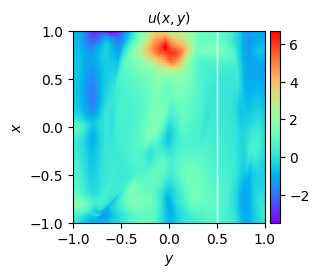

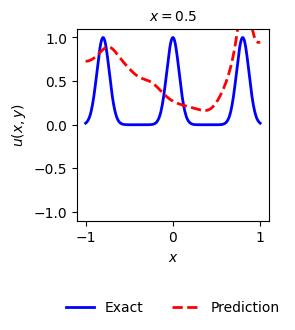

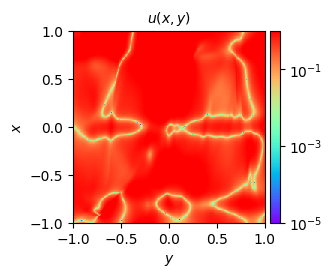

In [7]:
# 2000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt,)

Adversarial sample error:    134838.75


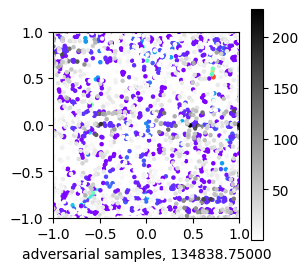

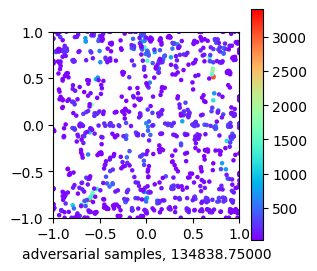

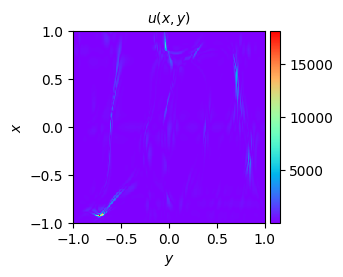

In [8]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(22781.6738, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(18070.4199, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(15287.5635, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(13464.0947, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(12182.1582, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(11207.6553, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(10437.3867, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(9812.6299, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(9295.2373, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(8859.3115, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(8488.0352, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(8169.7900, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(7893.8711, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(7651.6274, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(7436.6670, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(7244.2603, device='cuda:0', gr

12900 tensor(2302.8376, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2283.5645, device='cuda:0', grad_fn=<AddBackward0>)
13100 tensor(2264.4978, device='cuda:0', grad_fn=<AddBackward0>)
13200 tensor(2249.5190, device='cuda:0', grad_fn=<AddBackward0>)
13300 tensor(2225.8816, device='cuda:0', grad_fn=<AddBackward0>)
13400 tensor(2207.1667, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(2190.3806, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(2168.8682, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(2150.6350, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(2130.8018, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(2112.5693, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2096.2197, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(2077.4194, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(2059.4143, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(2044.3184, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(2026.3920, d

25600 tensor(1209.8958, device='cuda:0', grad_fn=<AddBackward0>)
25700 tensor(1206.1383, device='cuda:0', grad_fn=<AddBackward0>)
25800 tensor(1202.9713, device='cuda:0', grad_fn=<AddBackward0>)
25900 tensor(1200.9575, device='cuda:0', grad_fn=<AddBackward0>)
26000 tensor(1197.5786, device='cuda:0', grad_fn=<AddBackward0>)
26100 tensor(1196.1721, device='cuda:0', grad_fn=<AddBackward0>)
26200 tensor(1189.8567, device='cuda:0', grad_fn=<AddBackward0>)
26300 tensor(1186.5326, device='cuda:0', grad_fn=<AddBackward0>)
26400 tensor(1185.7672, device='cuda:0', grad_fn=<AddBackward0>)
26500 tensor(1180.4115, device='cuda:0', grad_fn=<AddBackward0>)
26600 tensor(1176.8064, device='cuda:0', grad_fn=<AddBackward0>)
26700 tensor(1174.0862, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(1170.8964, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1169.0020, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1166.8800, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1160.7529, d

38300 tensor(825.6855, device='cuda:0', grad_fn=<AddBackward0>)
38400 tensor(822.6420, device='cuda:0', grad_fn=<AddBackward0>)
38500 tensor(822.5081, device='cuda:0', grad_fn=<AddBackward0>)
38600 tensor(822.2621, device='cuda:0', grad_fn=<AddBackward0>)
38700 tensor(823.8046, device='cuda:0', grad_fn=<AddBackward0>)
38800 tensor(811.9055, device='cuda:0', grad_fn=<AddBackward0>)
38900 tensor(810.6947, device='cuda:0', grad_fn=<AddBackward0>)
39000 tensor(807.1807, device='cuda:0', grad_fn=<AddBackward0>)
39100 tensor(804.0238, device='cuda:0', grad_fn=<AddBackward0>)
39200 tensor(801.4958, device='cuda:0', grad_fn=<AddBackward0>)
39300 tensor(798.4540, device='cuda:0', grad_fn=<AddBackward0>)
39400 tensor(795.3910, device='cuda:0', grad_fn=<AddBackward0>)
39500 tensor(792.6724, device='cuda:0', grad_fn=<AddBackward0>)
39600 tensor(789.7723, device='cuda:0', grad_fn=<AddBackward0>)
39700 tensor(787.2625, device='cuda:0', grad_fn=<AddBackward0>)
39800 tensor(789.0515, device='cuda:0', 

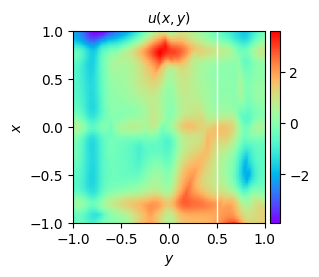

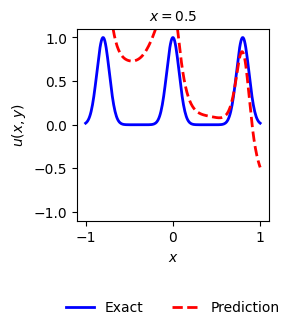

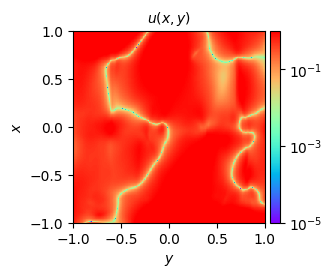

In [9]:
# 3000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    87529.31


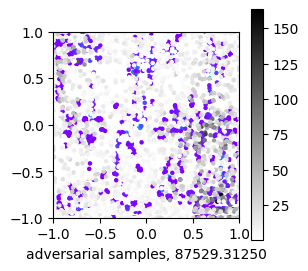

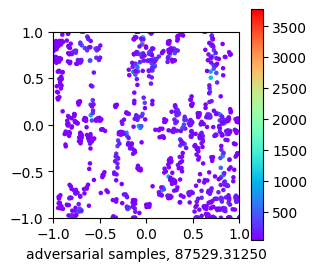

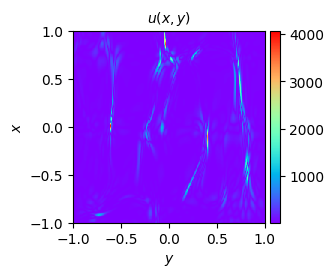

In [10]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(9591.4160, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(7460.2676, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(6325.0352, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(5549.5493, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(4978.0063, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(4533.2632, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(4114.6104, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(3740.9370, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(3528.3164, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(3358.4709, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(3210.1587, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(3076.1875, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(2953.1089, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(2839.2549, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(2733.7461, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(2635.8518, device='cuda:0', grad_fn=<

13000 tensor(262.1220, device='cuda:0', grad_fn=<AddBackward0>)
13100 tensor(257.9825, device='cuda:0', grad_fn=<AddBackward0>)
13200 tensor(254.7773, device='cuda:0', grad_fn=<AddBackward0>)
13300 tensor(252.1016, device='cuda:0', grad_fn=<AddBackward0>)
13400 tensor(251.0207, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(246.1524, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(243.0771, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(240.0535, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(237.3044, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(237.4523, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(232.6595, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(230.7071, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(226.9317, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(224.4715, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(222.4821, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(219.6424, device='cuda:0', 

25900 tensor(96.1485, device='cuda:0', grad_fn=<AddBackward0>)
26000 tensor(95.6538, device='cuda:0', grad_fn=<AddBackward0>)
26100 tensor(95.2748, device='cuda:0', grad_fn=<AddBackward0>)
26200 tensor(94.6960, device='cuda:0', grad_fn=<AddBackward0>)
26300 tensor(94.4791, device='cuda:0', grad_fn=<AddBackward0>)
26400 tensor(93.8092, device='cuda:0', grad_fn=<AddBackward0>)
26500 tensor(94.1298, device='cuda:0', grad_fn=<AddBackward0>)
26600 tensor(92.9202, device='cuda:0', grad_fn=<AddBackward0>)
26700 tensor(92.4758, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(92.1006, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(91.6018, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(91.1098, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(90.6489, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(93.0495, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(89.7871, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(89.4021, device='cuda:0', grad_fn=<AddBack

39000 tensor(56.3932, device='cuda:0', grad_fn=<AddBackward0>)
39100 tensor(55.2141, device='cuda:0', grad_fn=<AddBackward0>)
39200 tensor(55.0756, device='cuda:0', grad_fn=<AddBackward0>)
39300 tensor(55.1953, device='cuda:0', grad_fn=<AddBackward0>)
39400 tensor(54.5528, device='cuda:0', grad_fn=<AddBackward0>)
39500 tensor(54.3306, device='cuda:0', grad_fn=<AddBackward0>)
39600 tensor(54.1198, device='cuda:0', grad_fn=<AddBackward0>)
39700 tensor(53.9556, device='cuda:0', grad_fn=<AddBackward0>)
39800 tensor(53.9046, device='cuda:0', grad_fn=<AddBackward0>)
39900 tensor(53.5396, device='cuda:0', grad_fn=<AddBackward0>)
40000 tensor(53.3586, device='cuda:0', grad_fn=<AddBackward0>)
40100 tensor(53.2200, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(53.0085, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(52.7863, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(52.8387, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(52.5537, device='cuda:0', grad_fn=<AddBack

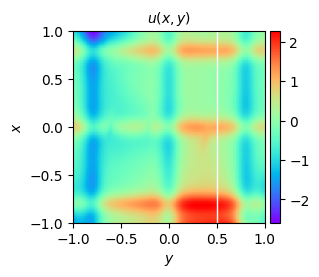

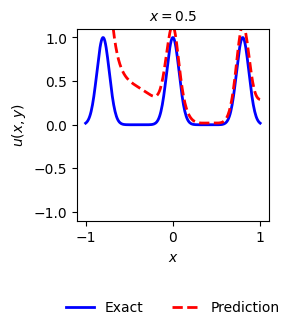

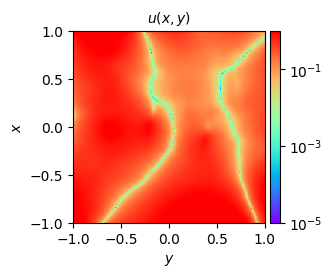

In [11]:
# 4000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    8105.8916


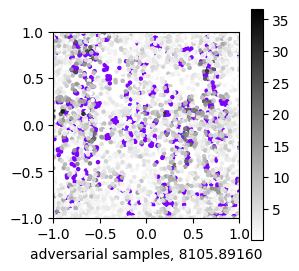

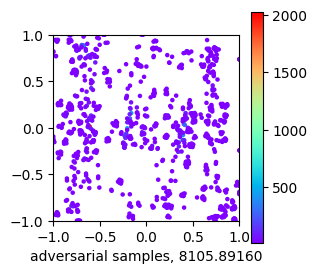

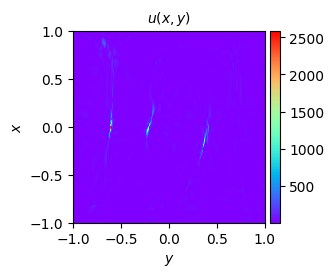

In [12]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(449.5119, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(365.0510, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(321.5693, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(292.0753, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(269.6004, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(251.5696, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(236.6444, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(223.9048, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(212.7805, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(202.8888, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(193.9682, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(185.8544, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(178.7808, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(171.5381, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(165.1760, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(159.2023, device='cuda:0', grad_fn=<AddBackward0>)
1

13300 tensor(43.7333, device='cuda:0', grad_fn=<AddBackward0>)
13400 tensor(43.5785, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(43.2260, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(43.1879, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(43.6887, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(42.6144, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(42.6506, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(42.7587, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(42.3747, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(41.9558, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(41.7208, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(41.3697, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(41.2842, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(40.9730, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(40.9307, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(41.0121, device='cuda:0', grad_fn=<AddBack

26400 tensor(26.7716, device='cuda:0', grad_fn=<AddBackward0>)
26500 tensor(26.6787, device='cuda:0', grad_fn=<AddBackward0>)
26600 tensor(26.4033, device='cuda:0', grad_fn=<AddBackward0>)
26700 tensor(26.3222, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(26.3834, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(26.1183, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(26.0759, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(26.2117, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(26.1058, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(25.8259, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(25.9969, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(25.7459, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(25.5842, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(25.6075, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(25.4538, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(25.3996, device='cuda:0', grad_fn=<AddBack

39500 tensor(19.1218, device='cuda:0', grad_fn=<AddBackward0>)
39600 tensor(19.1617, device='cuda:0', grad_fn=<AddBackward0>)
39700 tensor(19.4347, device='cuda:0', grad_fn=<AddBackward0>)
39800 tensor(19.2807, device='cuda:0', grad_fn=<AddBackward0>)
39900 tensor(18.9938, device='cuda:0', grad_fn=<AddBackward0>)
40000 tensor(19.1517, device='cuda:0', grad_fn=<AddBackward0>)
40100 tensor(18.9343, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(18.8536, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(18.8083, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(18.8598, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(18.7167, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(18.7059, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(18.7226, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(18.6396, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(18.6863, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(18.6262, device='cuda:0', grad_fn=<AddBack

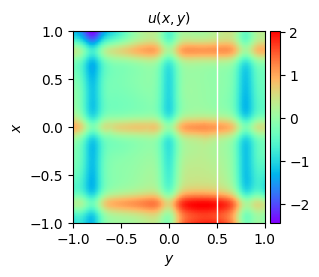

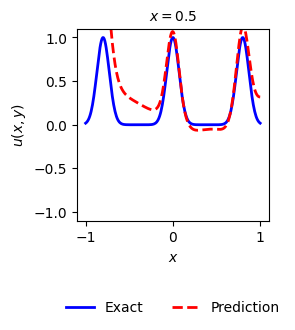

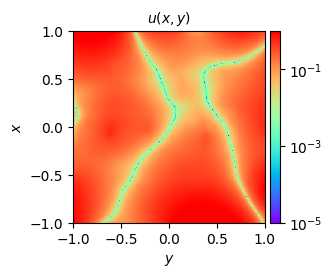

In [13]:
# 5000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    430.04672


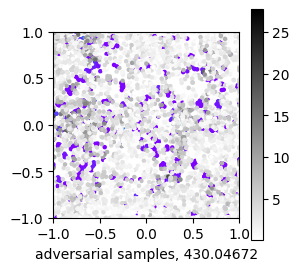

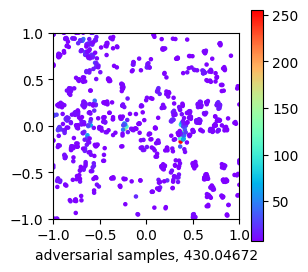

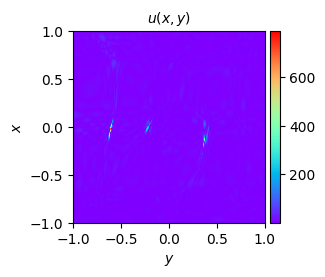

In [14]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(56.6123, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(51.5248, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(48.4646, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(46.3445, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(44.7532, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(43.4726, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(42.4138, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(41.5224, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(40.9827, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(40.6826, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(39.2200, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(38.7444, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(38.1106, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(37.4962, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(37.2778, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(36.5939, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(36.15

13300 tensor(20.0635, device='cuda:0', grad_fn=<AddBackward0>)
13400 tensor(20.0089, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(19.9595, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(20.1821, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(20.5220, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(19.9033, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(19.6868, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(19.8149, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(19.8898, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(19.9582, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(19.5690, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(19.4162, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(19.3875, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(19.2413, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(19.4338, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(19.1439, device='cuda:0', grad_fn=<AddBack

26400 tensor(13.8467, device='cuda:0', grad_fn=<AddBackward0>)
26500 tensor(13.8141, device='cuda:0', grad_fn=<AddBackward0>)
26600 tensor(13.7758, device='cuda:0', grad_fn=<AddBackward0>)
26700 tensor(13.9126, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(13.7468, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(13.7788, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(13.7352, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(13.7693, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(13.6933, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(13.5565, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(13.5560, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(13.6079, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(13.4886, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(13.4324, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(13.5825, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(13.8977, device='cuda:0', grad_fn=<AddBack

39500 tensor(10.1520, device='cuda:0', grad_fn=<AddBackward0>)
39600 tensor(10.5684, device='cuda:0', grad_fn=<AddBackward0>)
39700 tensor(10.1259, device='cuda:0', grad_fn=<AddBackward0>)
39800 tensor(11.6099, device='cuda:0', grad_fn=<AddBackward0>)
39900 tensor(10.0504, device='cuda:0', grad_fn=<AddBackward0>)
40000 tensor(10.0230, device='cuda:0', grad_fn=<AddBackward0>)
40100 tensor(10.0053, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(9.9758, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(10.2059, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(9.9440, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(9.9841, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(10.0236, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(9.8671, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(9.8402, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(9.9391, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(10.0628, device='cuda:0', grad_fn=<AddBackward0>

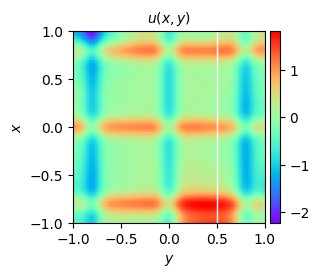

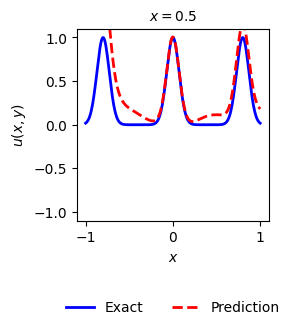

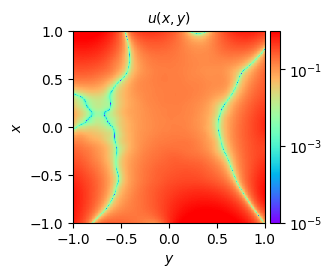

In [15]:
# 6000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    57.09335


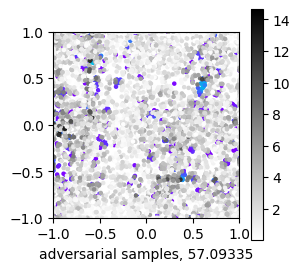

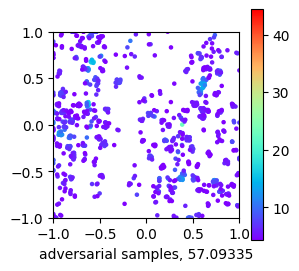

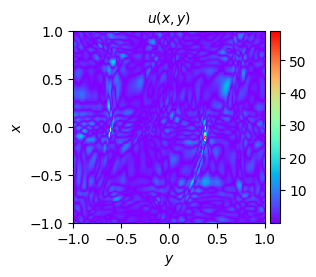

In [16]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(14.3985, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(14.0255, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(13.7970, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(13.6271, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(13.5708, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(13.3613, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(13.3233, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(13.2266, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(13.1190, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(12.9886, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(12.8934, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(12.8109, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(12.7553, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(12.6546, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(12.5895, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(12.5374, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(12.50

13400 tensor(8.1192, device='cuda:0', grad_fn=<AddBackward0>)
13500 tensor(8.1399, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(8.0652, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(8.1125, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(8.0172, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(7.9944, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(8.0990, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(8.0034, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(7.9470, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(7.9314, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(8.2290, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(7.8826, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(7.8315, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(7.8060, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(7.8247, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(7.9768, device='cuda:0', grad_fn=<AddBackward0>)
15000 te

26700 tensor(5.6882, device='cuda:0', grad_fn=<AddBackward0>)
26800 tensor(5.6143, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(5.6640, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(5.7038, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(5.6177, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(5.9883, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(6.1602, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(5.5422, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(5.5199, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(5.5392, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(5.4996, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(5.5251, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(5.4914, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(5.5383, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(5.4511, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(5.5373, device='cuda:0', grad_fn=<AddBackward0>)
28300 te

40000 tensor(4.4421, device='cuda:0', grad_fn=<AddBackward0>)
40100 tensor(4.2894, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(4.3433, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(4.3256, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(4.2840, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(4.2619, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(4.3586, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(4.2281, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(4.2264, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(4.2454, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(4.2876, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(4.2163, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(4.2250, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(4.3996, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(4.2111, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(4.6230, device='cuda:0', grad_fn=<AddBackward0>)
41600 te

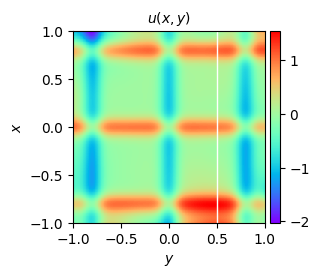

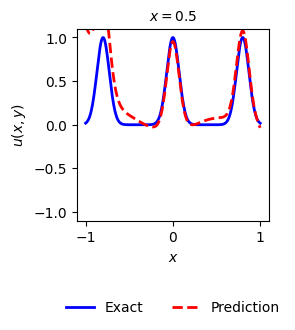

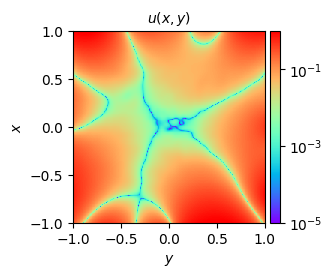

In [17]:
# 7000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    18.23025


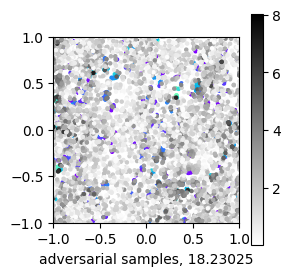

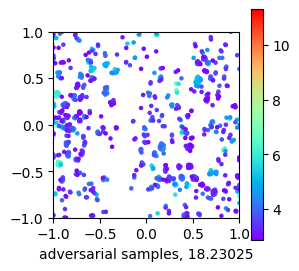

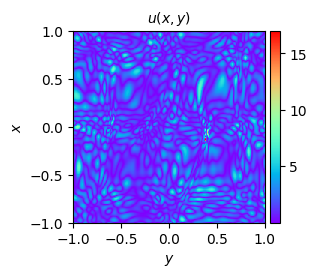

In [18]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(5.3994, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(5.3265, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(5.2761, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(5.2363, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(5.3372, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(5.1737, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(5.1473, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(5.1230, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(5.1794, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(5.0788, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(5.0612, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(5.1148, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(5.0200, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(5.0122, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(4.9840, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(5.0151, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(5.3661, device='cuda:

13500 tensor(4.1504, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(3.9615, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(3.8319, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(3.8358, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(4.5075, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(4.1185, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(3.8194, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(3.8173, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(3.7954, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(3.8424, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(3.8195, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(3.7574, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(3.7625, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(3.7481, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(3.7484, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.7368, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(3.0781, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(3.0738, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(3.0622, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(3.0609, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(3.0628, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(3.2335, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(3.0590, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(3.0998, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(3.2571, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(3.0406, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(3.0549, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(3.0335, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(3.0338, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(3.0847, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(3.0093, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(3.0078, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(2.6526, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(2.9481, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(2.6830, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(2.5655, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(2.5593, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(2.5751, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(2.5913, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(2.5403, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(2.5451, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(2.5548, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(2.5846, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(2.7972, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(2.5715, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(3.1711, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(2.5703, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(2.7492, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

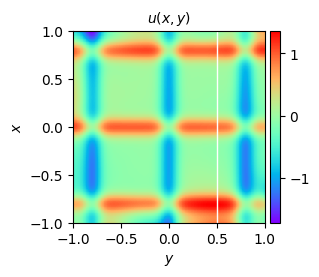

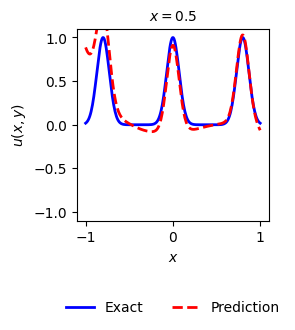

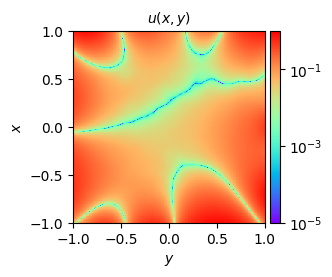

In [19]:
# 8000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

In [20]:
x_y_adv.shape

(1000, 2)

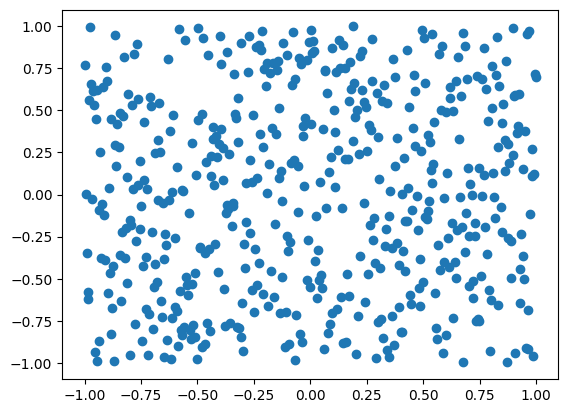

In [21]:
plt.scatter(x_y_train[:n_inner,1],x_y_train[:n_inner,0])

Adversarial sample error:    10.007695


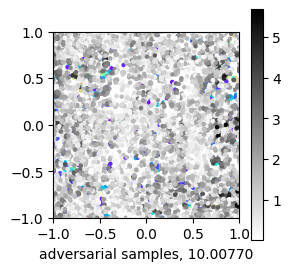

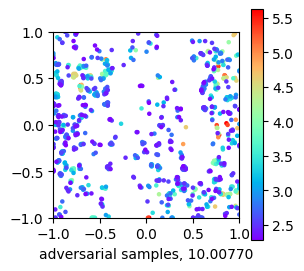

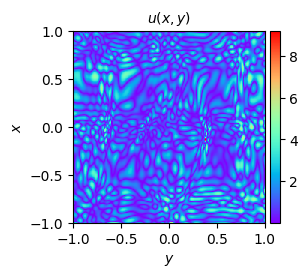

In [22]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(2.9674, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(2.9438, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(2.9286, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(2.9168, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(2.9074, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(2.8984, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(2.8899, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(2.8827, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(2.8764, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(2.8688, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(2.8647, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(2.9183, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(2.8616, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(2.8697, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(2.8444, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(2.8699, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(3.0496, device='cuda:

13500 tensor(2.5120, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(2.4618, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(2.4370, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(2.4354, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(2.4337, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2.4446, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(2.4283, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(2.4919, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(2.4491, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(2.4708, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(2.4573, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(2.4254, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(2.4265, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(2.4247, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(2.5970, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.4328, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(2.2055, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(2.1683, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(2.3220, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(2.1672, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(2.1925, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(2.2045, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(2.1260, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(2.1237, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(2.1200, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(2.1505, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(2.1589, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(2.1146, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(2.2398, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(2.1187, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(2.1096, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(2.2161, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(1.8984, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.9329, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(1.9852, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.9390, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(1.9490, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(1.9309, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.9508, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(1.9061, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.9270, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(1.9621, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(1.9283, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(1.9285, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(2.0968, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(1.8934, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(1.8777, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(1.8804, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

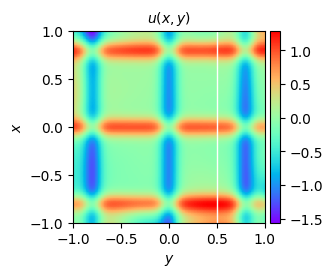

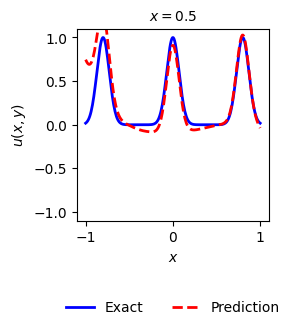

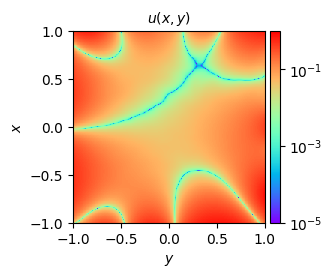

In [23]:
# 9000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

In [24]:
with open("model9k.pickle", "wb") as fp:
    pickle.dump(PINN.state_dict(), fp)
    
with open("points9k.pickle", "wb") as fp:
    pickle.dump({"x_y_train":x_y_train, "x_y_boundary":x_y_boundary, "u_boundary":u_boundary}, fp)

Adversarial sample error:    5.4733267


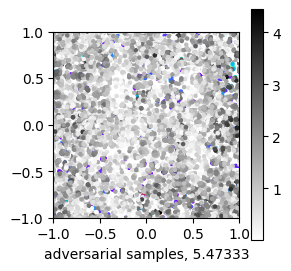

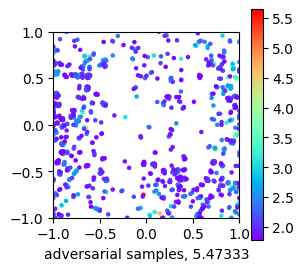

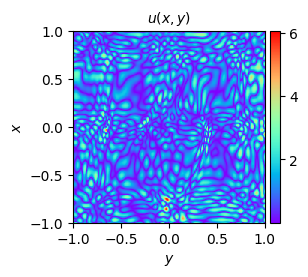

In [25]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(2.1454, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(2.1364, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(2.1311, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(2.1268, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(2.1230, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(2.1195, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(2.1163, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(2.1131, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(2.1102, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(2.1100, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(2.1156, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(2.1128, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(2.0991, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(2.0967, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(2.0942, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(2.0939, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(2.1000, device='cuda:

13500 tensor(2.0143, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(2.1843, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(1.8865, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(1.9127, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.8849, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(1.8885, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(1.9001, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(1.9873, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(2.1724, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(1.8984, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(1.9773, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(2.0797, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(1.9055, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.8764, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(1.7867, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1.7387, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1.7388, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1.7191, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(1.7112, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(1.7106, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(1.7156, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(1.7055, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(1.7045, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(1.7427, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(1.7083, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(1.7065, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(1.7246, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(1.7018, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(1.7006, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(1.5738, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.5712, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(1.5949, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.8111, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(1.7278, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(1.5993, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.5783, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(1.6037, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.8673, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(1.6060, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(1.5827, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(1.6723, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(1.5554, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(1.5561, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(1.5860, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(1.5703, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

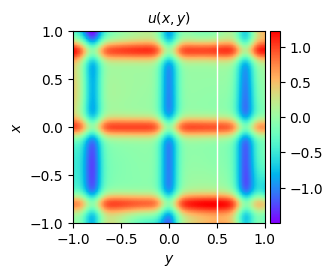

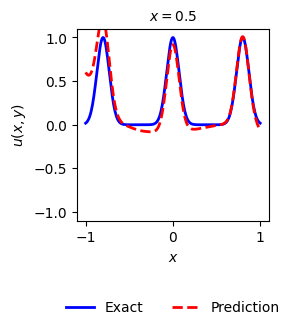

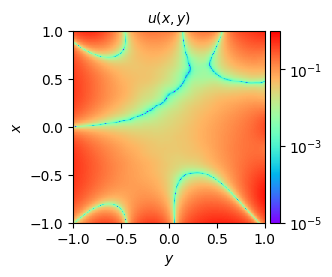

In [26]:
# 10000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    4.2599063


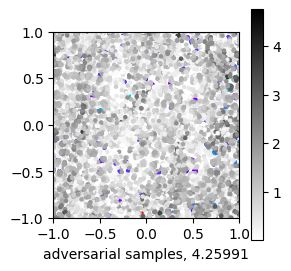

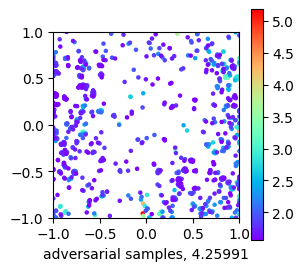

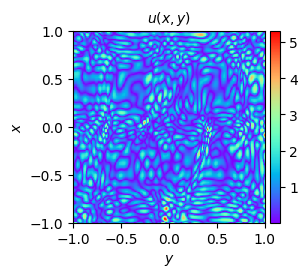

In [27]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(1.7321, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(1.7261, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(1.7228, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(1.7203, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(1.7180, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(1.7160, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(1.7141, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(1.7122, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(1.7104, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(1.7088, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(1.7071, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(1.7072, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(1.7040, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(1.7046, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(1.7080, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(1.7300, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(1.6977, device='cuda:

13500 tensor(1.5816, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(1.5628, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(1.5637, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(1.5750, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(1.5664, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.5742, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(1.6057, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(1.5614, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(1.5589, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(1.5585, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(1.5529, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(1.5533, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(1.5560, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(1.6224, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(1.9828, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.6047, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(1.4404, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1.4371, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1.4402, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1.5094, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(1.5224, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(1.4959, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(1.4342, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(1.4485, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(1.4328, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(1.4356, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(1.4633, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(1.4672, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(1.4280, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(1.4270, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(1.4622, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(1.4838, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(1.3350, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.3337, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(1.3407, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.4318, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(1.3483, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(1.4583, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.3646, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(1.3599, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.3223, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(1.3333, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(1.3195, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(1.3344, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(1.5675, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(1.4697, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(1.3152, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(1.5323, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

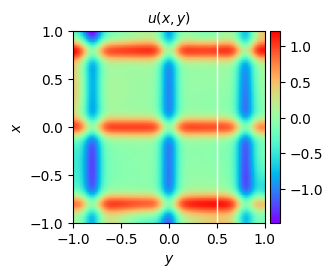

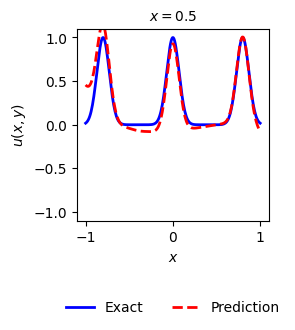

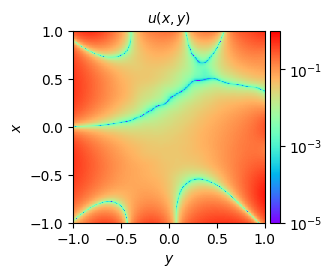

In [28]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    3.394902


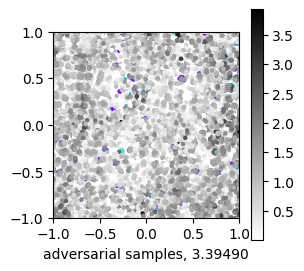

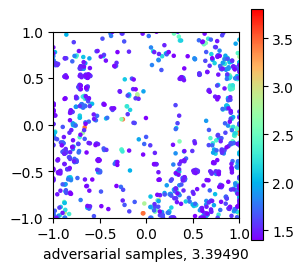

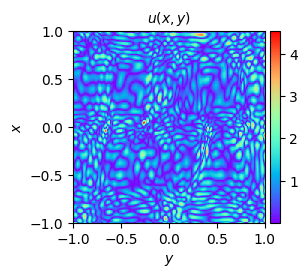

In [29]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(1.4346, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(1.4300, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(1.4277, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(1.4260, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(1.4246, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(1.4232, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(1.4219, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(1.4277, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(1.4338, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(1.4183, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(1.4171, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(1.4167, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(1.4515, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(1.4143, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(1.4439, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(1.4181, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(1.5097, device='cuda:

13500 tensor(1.3858, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(1.3326, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(1.3492, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(1.3091, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(1.3264, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.3446, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(1.3177, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(1.3243, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(1.3157, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(1.4089, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(1.3033, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(1.3698, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(1.3661, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(1.3258, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.3134, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(1.2182, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1.2360, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1.2118, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1.2219, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(1.2483, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(1.2116, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(1.2167, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(1.3312, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(1.2875, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(1.2087, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(1.2624, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(1.2081, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(1.2052, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(1.4269, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(1.2665, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(1.2999, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(1.1522, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.1292, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(1.1282, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.1636, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(1.7444, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(1.1214, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.1315, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(1.1259, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.1230, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(1.2496, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(1.1486, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(1.1800, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(1.2712, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(1.1520, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(1.1161, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(1.1155, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

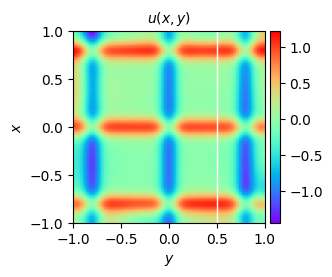

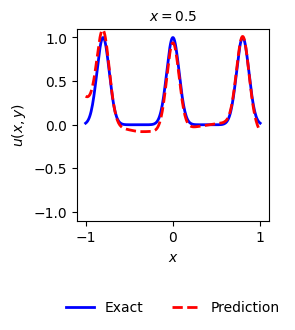

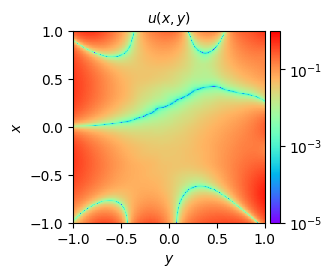

In [30]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    2.942756


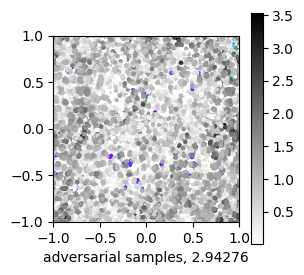

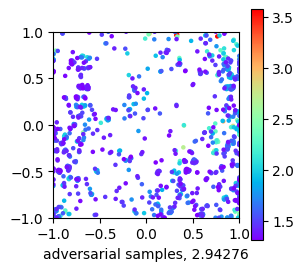

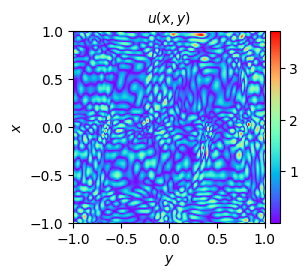

In [31]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(1.2033, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(1.1990, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(1.1973, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(1.1959, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(1.1947, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(1.1936, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(1.1926, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(1.1916, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(1.1907, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(1.1956, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(1.2028, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(1.1879, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(1.1881, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(1.1861, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(1.3313, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(1.1846, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(1.1841, device='cuda:

13500 tensor(1.1089, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(1.1072, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(1.1925, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(1.1096, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(1.7557, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.1077, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(1.3535, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(1.1375, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(1.2833, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(1.1217, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(1.1062, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(1.1002, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(1.2968, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(1.1274, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(1.2117, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.1201, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(1.0346, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1.0400, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1.1453, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(1.1079, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(1.0777, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(1.0550, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(1.0735, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(1.0292, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(1.0374, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(1.2364, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(1.9748, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(1.0630, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(1.0331, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(1.1671, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(1.0276, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(1.0279, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.9739, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.0955, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(1.0981, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.9827, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.9637, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(1.4782, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.0058, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.9773, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.0193, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(1.0990, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.9620, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(1.1507, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(1.0114, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.9804, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.9622, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.9685, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

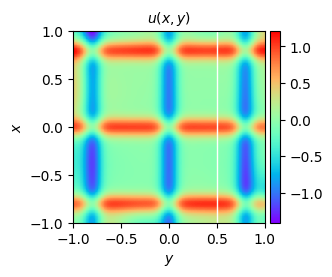

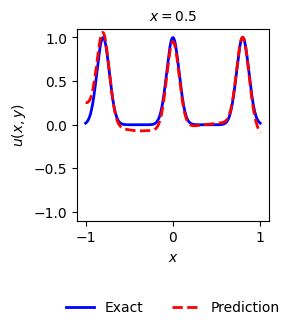

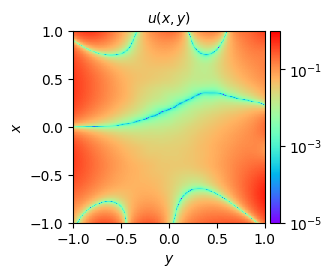

In [32]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    2.4335492


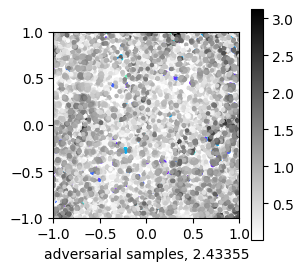

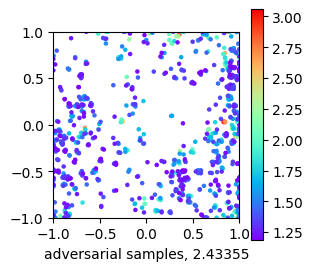

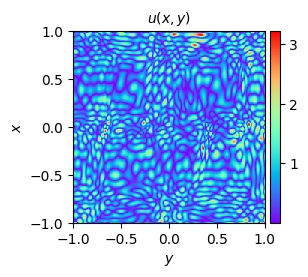

In [33]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(1.0298, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(1.0269, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(1.0255, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(1.0244, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(1.0235, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(1.0227, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(1.0219, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(1.0214, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(1.0397, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(1.0200, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(1.0284, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(1.0192, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(1.0183, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(1.3083, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(1.1511, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(1.0442, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(1.0291, device='cuda:

13500 tensor(1.0192, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(1.3615, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.9667, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.9592, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.9559, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.0198, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.9720, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.9548, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.9784, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.9574, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.9515, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.9545, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.9722, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.9567, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.9627, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.9627, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.8971, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.9092, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(1.3849, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.9004, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.8981, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(1.1237, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.9054, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.9026, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(1.0247, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.8932, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.8933, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.8920, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.8927, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.8913, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.8914, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.9218, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.8486, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(1.0663, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.9250, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.1459, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.8409, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.8412, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.8404, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.8414, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.9385, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.9436, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.8683, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.8476, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.8482, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.8392, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.8943, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

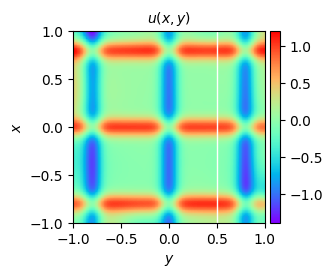

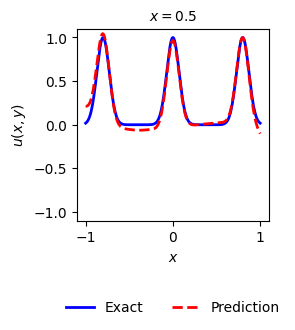

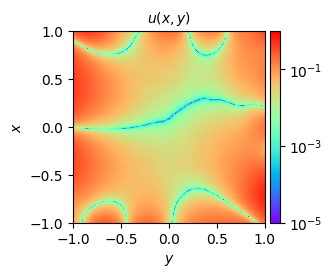

In [34]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    5.2841854


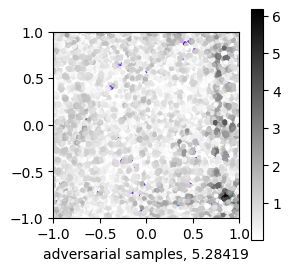

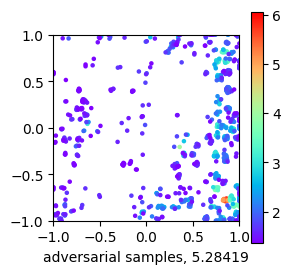

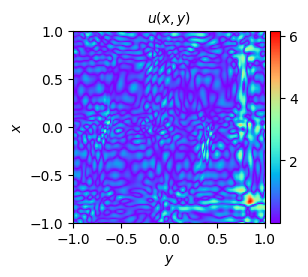

In [35]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.8571, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.8552, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.8543, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.8528, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.8523, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(0.8519, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.9224, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.8508, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.8504, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.8770, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.9059, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.8483, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.8906, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.8549, device='cuda:

13500 tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.8543, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.8690, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.8750, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.8217, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.8059, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.8027, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.8066, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.8020, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.8161, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.8017, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.8007, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.8007, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.8760, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.7716, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.7748, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.8227, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.8957, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.7869, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.7658, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.7718, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.7691, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.7621, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.8710, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.7663, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.7898, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.7339, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.7458, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(1.0785, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.7229, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.7228, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.7252, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.7360, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.7368, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.7257, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.7363, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.7723, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

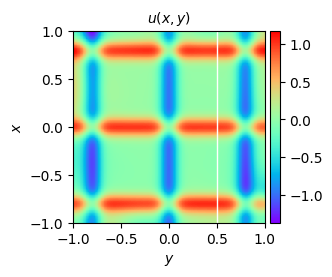

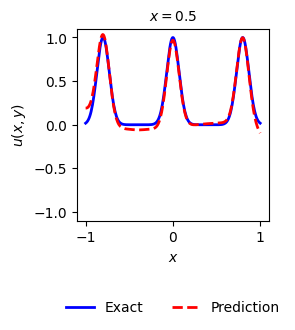

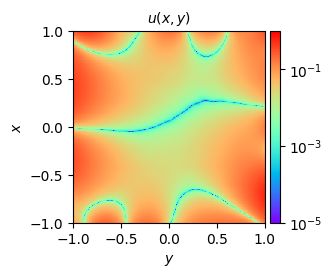

In [36]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    2.3823218


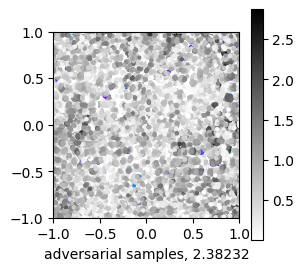

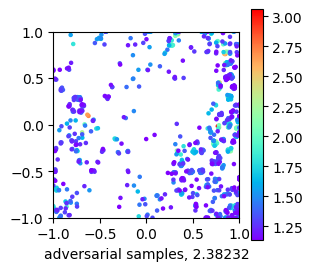

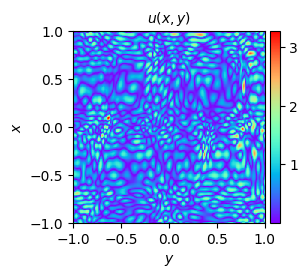

In [37]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.7830, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.7778, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.7766, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.7762, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(0.7756, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.7747, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.7748, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.9557, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.7734, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.8005, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(0.7726, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.7785, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.8083, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.7724, device='cuda:

13500 tensor(0.7371, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.7375, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.7975, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.7811, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.7449, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.7404, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.7441, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.7329, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.7362, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.7476, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.7077, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.8544, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.7117, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.9831, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.8464, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.7046, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(1.0270, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.8112, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.7339, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.7027, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.6963, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.7605, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.7622, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.7778, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.6922, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.6859, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(1.0274, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.7777, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.6804, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.6888, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.8281, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

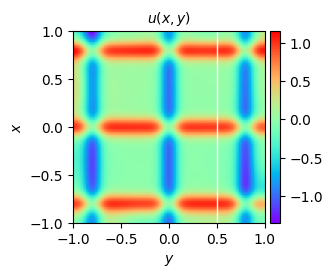

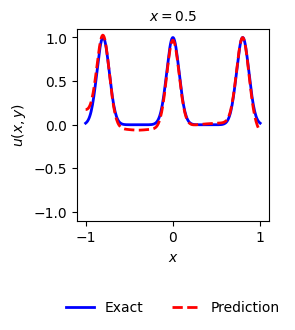

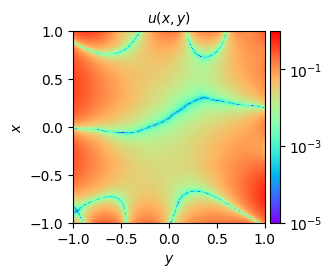

In [38]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    2.331638


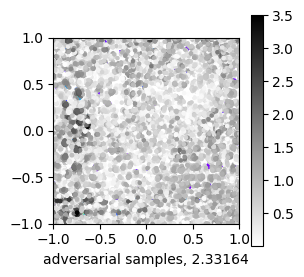

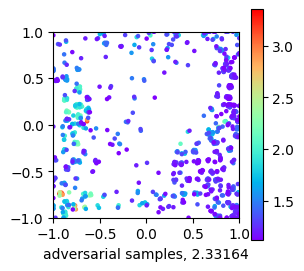

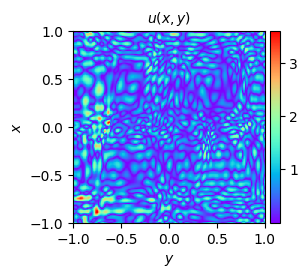

In [39]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.6899, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.7288, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(1.6763, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.7176, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.6987, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.6873, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.6934, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.6942, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(1.0199, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.6876, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.7066, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.7838, device='cuda:

13500 tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.6582, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.7109, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.0551, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.6595, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.7791, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.6730, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.7834, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(1.0579, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.9379, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.6412, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.8661, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.6289, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.8550, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.8238, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.8182, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.6198, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.6027, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(1.0877, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.6037, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.6049, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.7267, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

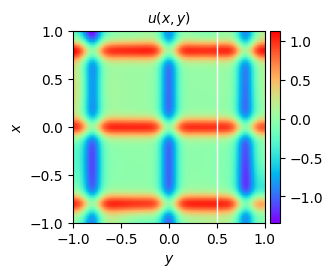

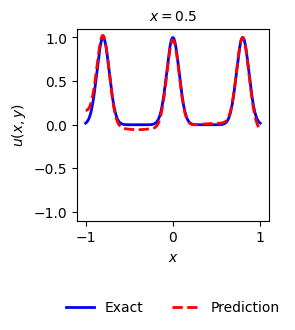

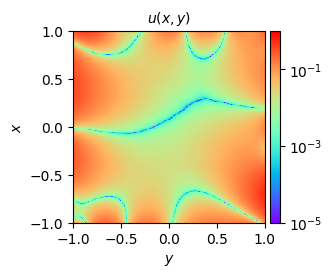

In [40]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    1.4561548


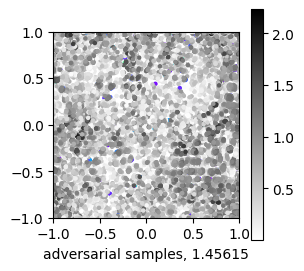

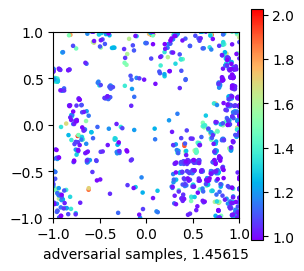

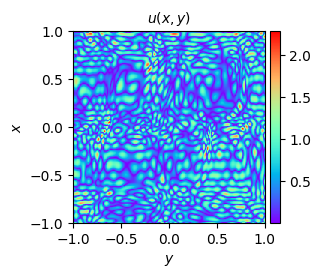

In [41]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.6332, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.6383, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(0.7296, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.6323, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.6449, device='cuda:

13500 tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.7578, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.6851, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.6389, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.6959, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.6610, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(1.0258, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.6352, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.7865, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.0426, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.8603, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.6245, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(1.0338, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.6678, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.6326, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.7082, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.6972, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.6938, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.6988, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

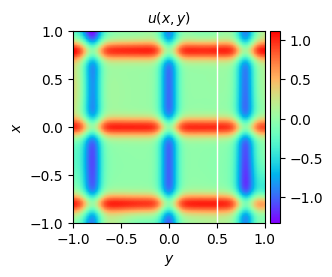

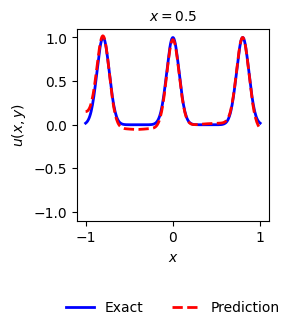

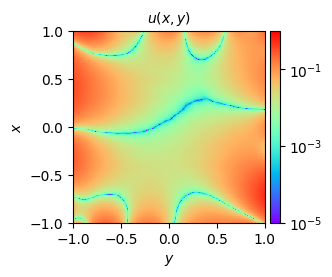

In [42]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    1.7121265


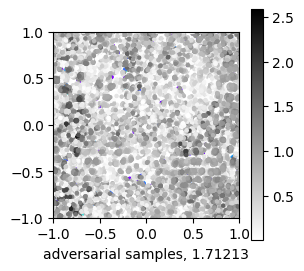

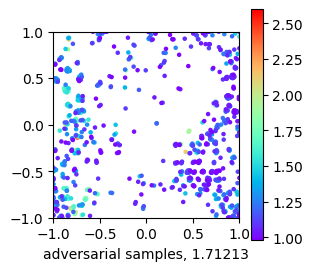

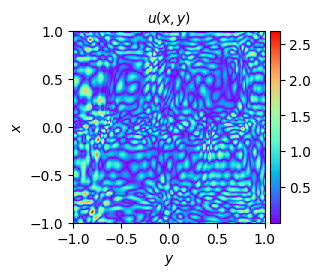

In [43]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.7321, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(0.5731, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.6544, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.6302, device='cuda:

13500 tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.7335, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.7810, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.8160, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.8605, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.6360, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.5178, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.5418, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

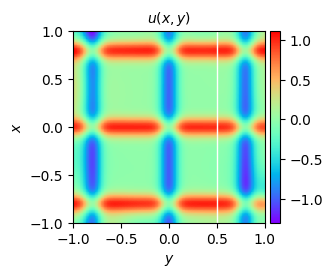

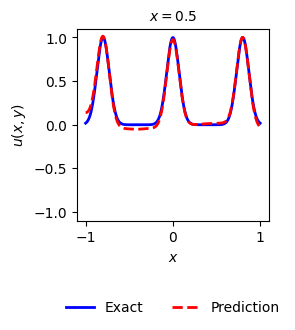

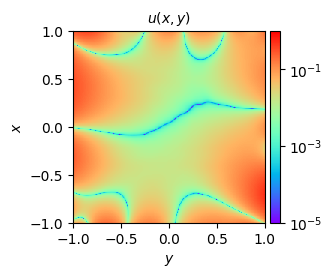

In [44]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

Adversarial sample error:    1.137706


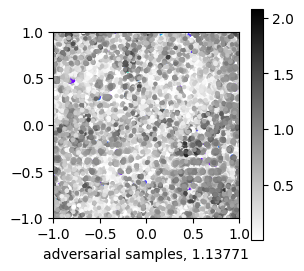

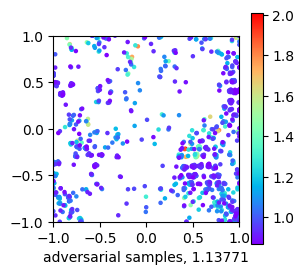

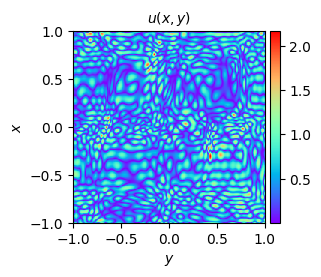

In [45]:
x_y_train = np.vstack([x_y_train, x_y_adv])
x_y_adv = generate_attack_samples(PINN, device, x_y_train)

100 tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)
400 tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)
600 tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)
700 tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)
800 tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)
900 tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)
1100 tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)
1200 tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)
1300 tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)
1400 tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)
1600 tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)
1700 tensor(0.5291, device='cuda:

13500 tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>)
13600 tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)
13700 tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)
13800 tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)
13900 tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)
14100 tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)
14200 tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)
14300 tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)
14400 tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)
14500 tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)
14600 tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)
14700 tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)
14800 tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)
14900 tensor(0.6828, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)
15100 te

26800 tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)
26900 tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)
27000 tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)
27100 tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)
27200 tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)
27300 tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)
27400 tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)
27500 tensor(0.8048, device='cuda:0', grad_fn=<AddBackward0>)
27600 tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)
27700 tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)
27800 tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)
27900 tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)
28000 tensor(0.5974, device='cuda:0', grad_fn=<AddBackward0>)
28100 tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)
28200 tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)
28300 tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)
28400 te

40100 tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)
40200 tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)
40300 tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)
40400 tensor(0.4861, device='cuda:0', grad_fn=<AddBackward0>)
40500 tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)
40600 tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)
40700 tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)
40800 tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)
40900 tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)
41000 tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)
41100 tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)
41200 tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)
41300 tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)
41400 tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)
41500 tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)
41600 tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>)
41700 te

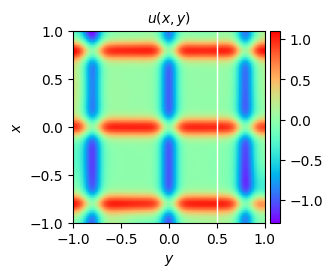

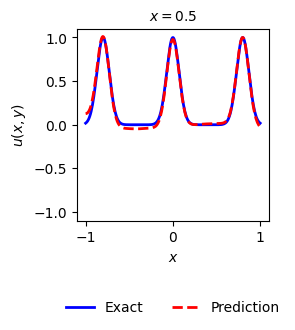

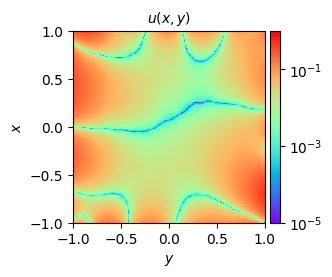

In [46]:
# 11000
retrain(PINN, x_y_train, x_y_adv, x_y_boundary, u_boundary, x_y_test, u_test, U_gt)

In [47]:
with open("model_well_traned.pickle", "wb") as fp:
    pickle.dump(PINN.state_dict(), fp)
    
with open("points_well_trained.pickle", "wb") as fp:
    pickle.dump({"x_y_train":x_y_train, "x_y_boundary":x_y_boundary, "u_boundary":u_boundary}, fp)